run with `popstrucure` env

In [1]:
import os
import vcf
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from matplotlib.pyplot import figure
import glob
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import statistics
import allel
from collections import defaultdict
from itertools import combinations
from haversine import haversine
from skbio.stats.distance import mantel
from scipy.stats import ttest_ind

# from tqdm import tqdm



# import os
# import allel
# import numpy as np
# import pandas as pd
# import vcf
# import matplotlib.pyplot as plt
# from collections import defaultdict
# from matplotlib.pyplot import figure
# from tqdm import tqdm
# from pathlib import Path
# from itertools import groupby
# from IPython.display import Image 
# import glob
# import scipy
# from haversine import haversine
import cartopy.crs as ccrs
import cartopy.feature as cf
from pykrige.ok import OrdinaryKriging


During startup - Warning messages:
1: package ‘methods’ was built under R version 4.2.3 
2: package ‘datasets’ was built under R version 4.2.3 
3: package ‘utils’ was built under R version 4.2.3 
4: package ‘grDevices’ was built under R version 4.2.3 
5: package ‘graphics’ was built under R version 4.2.3 
6: package ‘stats’ was built under R version 4.2.3 


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

os.chdir(proj_dir)

In [3]:
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

# initial PCA

In [5]:
Path("{}/initial_pca".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/initial_pca".format(results_dir))

In [ ]:
#maf 05
vcftools \
    --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
    --maf 0.05 \
    --chr NC_067196.1 \
    --chr NC_067197.1 \
    --chr NC_067198.1 \
    --chr NC_067199.1 \
    --chr NC_067200.1 \
    --chr NC_067201.1 \
    --chr NC_067202.1 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >autosomes_maf05.vcf

In [ ]:
#ld filtering
plink \
    --vcf autosomes_maf05.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 25 5 0.20 \
    --out autosomes_maf05_ld_filtered

In [ ]:
vcftools \
    --vcf autosomes_maf05.vcf \
    --exclude autosomes_maf05_ld_filtered.prune.out \
    --recode \
    --recode-INFO-all \
    --stdout \
    >autosomes_maf05_ld_filtered.vcf

Calculate PCA

In [ ]:
%%bash
conda run -n popstructure --cwd . \
    plink \
        --vcf autosomes_maf05_ld_filtered.vcf \
        --pca \
        --double-id \
        --allow-extra-chr \
        --out pca

In [55]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep=" ", header=None)
pca_df.columns=["sample_name", "x"] + list(range(1, 21))
pca_df=pca_df.drop("x", axis=1)

# #now add sample info (including location data)
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', on='sample_name')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["country"].astype(str)

#set marker colors based on the country
cmap = cm.get_cmap('nipy_spectral')
colors={}

countries = sorted(pca_df["country"].unique().astype(str))

i=0
for country in countries:
    colors[country]=cmap(np.linspace(0,1,len(countries))[i])
    i+=1

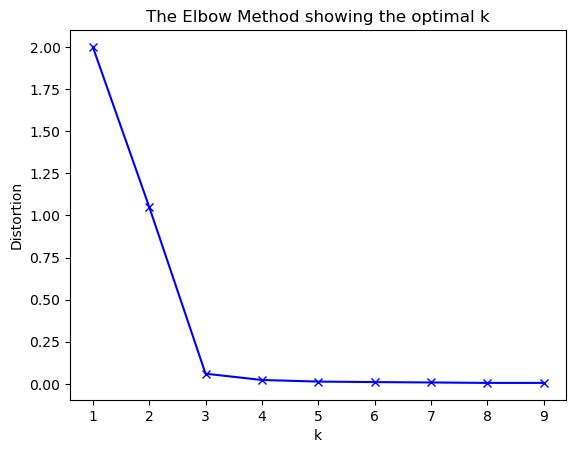

In [56]:
#code modified from https://predictivehacks.com/k-means-elbow-method-code-for-python/

#get pc1,pc2
pc1_pc2=pca_df.iloc[:,1:3].values.tolist()

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto')
    kmeanModel.fit(pc1_pc2)
    distortions.append(kmeanModel.inertia_)
    
    
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.savefig("kmeans_elbow.png", dpi=300)
plt.savefig("kmeans_elbow.svg")

plt.show()

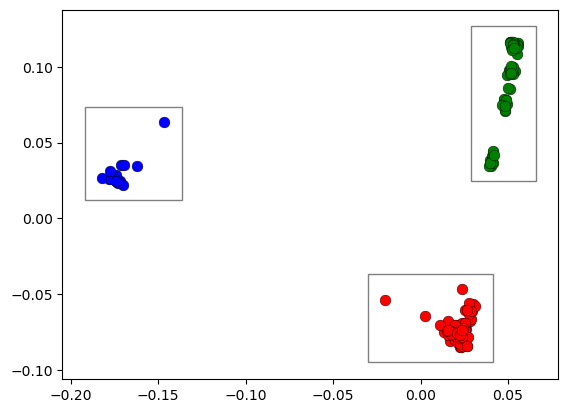

In [57]:
fig, ax = plt.subplots()

#visualize the three groups
kmeans=KMeans(n_clusters=3, random_state=0, n_init='auto').fit_predict(pc1_pc2)
pca_df["kmeans_group"]=kmeans

k_colors={0:"red", 1:"green", 2:"blue" }

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    color=k_colors[kmeans[index]]
    plt.scatter(x, y, color=color, edgecolor="black", linewidths=0.3, s=60)
    

#add rectangles
for k in [0,1,2]:
    x1=pca_df[pca_df["kmeans_group"]==k][1].min()
    x2=pca_df[pca_df["kmeans_group"]==k][1].max()

    y1=pca_df[pca_df["kmeans_group"]==k][2].min()
    y2=pca_df[pca_df["kmeans_group"]==k][2].max()

    rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()



In [59]:
pca_species = {0: "s_haematobium",
               1: "s_haematobium",
               2: "s_bovis"}

In [60]:
pca_df["pca_species"] = str("Na")

for index, row in pca_df.iterrows():
    pca_df.at[index,"pca_species"] = pca_species[row["kmeans_group"]]

In [61]:
outgroups = {"guineensis_saotome_ERR119612": "s_guineensis",
             "intercalatum_drcongo_ERR119613": "s_intercalatum",
             "margrebowiei_zambia_ERR310940": "s_margrebowiei",
             "matthei_zambia_ERR103051": "s_matthei"}

for outgroup in outgroups.keys():
    pca_df.loc[pca_df["sample_name"] == outgroup, "pca_species"] = outgroups[outgroup]

In [62]:
pca_df.to_csv("pca_df.csv", index=False, sep=",", header=False, mode='w', na_rep='NaN')

pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species
0,Sb_NG_au_1.2,-0.174693,0.025622,0.001506,0.004149,0.035574,0.055396,0.032718,-0.019520,0.007569,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
1,Sb_NG_au_2.10,-0.173848,0.025251,0.001886,0.005161,0.036499,0.060013,0.032135,-0.019021,0.003526,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
2,Sb_NG_au_2.13,-0.174493,0.025294,0.001699,0.001562,0.037332,0.060250,0.030712,-0.022199,0.003399,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
3,Sb_NG_au_2.5,-0.173862,0.025171,0.003061,-0.001638,0.037943,0.059797,0.031391,-0.015780,0.000577,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
4,Sb_NG_au_2.6,-0.173011,0.025618,0.001527,0.005455,0.038614,0.061741,0.032516,-0.022343,0.009809,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023482,-0.078226,-0.011342,-0.059942,0.017520,-0.043266,0.041449,-0.016997,0.021684,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
167,ssp_niger_libore_168,0.022237,-0.077112,-0.019412,-0.059978,0.006374,-0.004766,0.030555,-0.041763,0.080463,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
168,ssp_niger_libore_169,0.023857,-0.073894,-0.020205,-0.050080,0.015119,-0.015182,0.038133,-0.019263,0.036911,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium
169,ssp_niger_libore_173,0.026630,-0.083945,-0.003698,-0.069531,-0.009745,-0.085123,0.095988,-0.108937,0.082528,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium


In [63]:
#set marker shapes based on PRESUMED species
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guineensis'   : "P",
            's_margrebowiei' : "D", 
            's_matthei'      : "s",}

so based off this info I think that anything in group 0 or 1 (red or green) is a Sh and anything in blue is a Sb.
Update the df accordingly to indicate `pca_species`.

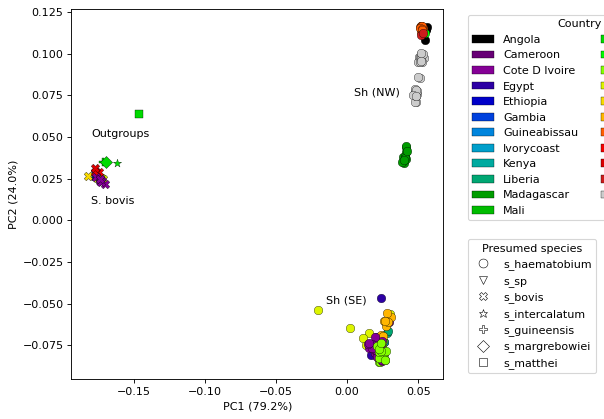

In [64]:
#plot the results
#fig, ax = plt.subplots()
figure(figsize=(6, 6), dpi=80)

#figure(figsize=(6,6))

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    marker=markers[row["pca_species"]]
    color=colors[row["country"]]
    
    plt.scatter(x, y, marker=marker, color=color, edgecolor="black", linewidths=0.3, s=60)
    
# #set title
# num_snvs="^"
# plt.title("{} SNPs (MAF05, LD)".format(num_snvs))

#set x label (eigen 1)
eigen_vals=[line.strip() for line in open("pca.eigenval", 'r')]

pc1=eigen_vals[0]
plt.xlabel("PC1 ({:.1f}%)".format(float(pc1)))

#set x label (eigen 2)
pc2=eigen_vals[1]
plt.ylabel("PC2 ({:.1f}%)".format(float(pc2)))

#add rectangles
for k in [0,1,2]:
    x1=pca_df[pca_df["kmeans_group"]==k][1].min()
    x2=pca_df[pca_df["kmeans_group"]==k][1].max()

    y1=pca_df[pca_df["kmeans_group"]==k][2].min()
    y2=pca_df[pca_df["kmeans_group"]==k][2].max()

    rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

#make legend for countries
country_patches=[]
for country in colors.keys():
    country_patch=mpatches.Patch(facecolor=colors[country], 
                         edgecolor="black", 
                         label=country.title().replace("_", " "),
                         linewidth=0.3)
    country_patches.append(country_patch)
    
#country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=2)
#country_legend = plt.legend(title="Country", handles=country_patches, scatterpoints=1, loc='upper right', ncol=3, prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)

#plt.gca().add_artist(country_legend)

#make legend for species
ssp_marker   = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='v',
                          markersize=8, markeredgewidth=0.5, label='${S. sp.}$')
ssh_marker   = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white",  marker='o',
                          markersize=8, markeredgewidth=0.5, label='${S. haematobium}$')
ssb_marker   = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='X',
                          markersize=8, markeredgewidth=0.5, label='${S. bovis}$')
sg_marker    = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='P',
                          markersize=8, markeredgewidth=0.5, label='${S. guiniensis}$')
si_marker    = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='*',
                          markersize=8, markeredgewidth=0.5, label='${S. intercalatum}$')
smar_marker  = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='D',
                          markersize=8, markeredgewidth=0.5, label='${S. margrebowiei}$')
smat_marker  = mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker='s',
                          markersize=8, markeredgewidth=0.5, label='${S. matthei}$')
prop={'size': 8}
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], bbox_to_anchor=(1.05, 0.3))
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker, sg_marker, si_marker, smar_marker, smat_marker], loc='lower right', prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)


#add kmeans group annotation
plt.annotate("Sh (NW)",   xy=(0.005,  0.075))
plt.annotate("Sh (SE)",   xy=(-0.015, -0.05))
plt.annotate("S. bovis",        xy=(-0.18,    0.01))
plt.annotate("Outgroups", xy=(-0.18,    0.05))


# make legend for countries
country_legend = plt.legend(
    title="Country", 
    handles=[mpatches.Patch(facecolor=colors[country], edgecolor="black", label=country.title().replace("_", " "), linewidth=0.3) for country in colors.keys()],
    scatterpoints=1, 
    bbox_to_anchor=(1.05, 1.0), 
    loc='upper left', 
    ncol=2
)

# make legend for species
species_legend = plt.legend(
    title="Presumed species",
    handles=[
        mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker=marker, markersize=8, markeredgewidth=0.5, label=label)
        for marker, label in zip(markers.values(), markers.keys())
    ],
    scatterpoints=1,
    bbox_to_anchor=(1.05, 0.0),
    loc='lower left',
    ncol=1
)

plt.gca().add_artist(country_legend)
#save
plt.savefig("pca.png", dpi=300, bbox_inches='tight', pad_inches=2)
plt.savefig("pca.svg", bbox_inches='tight', pad_inches=2)

#display
plt.show()
plt.close()

In [65]:
#generate labeles for downstream work
k_pop_labels={0: "sh_nw", 
              1: "sh_se", 
              2: "sb" }

kmeans_labels=[]
for index, row in pca_df.iterrows():
    kmeans_labels.append(k_pop_labels[row["kmeans_group"]])

pca_df["kmeans_label"]=kmeans_labels

#change the outgroups to the correct species
for outgroup in outgroups.keys():
    pca_df.loc[pca_df["sample_name"] == outgroup, "kmeans_label"] = outgroups[outgroup]
    
    
pca_df.to_csv("pca_df.csv", index=False, sep=",", header=True, mode='w', na_rep='NaN')

# Mapping rates

In [4]:
Path("{}/mapping_rates".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/mapping_rates".format(results_dir))

In [5]:
pca_df=pd.read_csv("../initial_pca/pca_df.csv")

In [8]:
pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.174693,0.025622,0.001506,0.004149,0.035574,0.055396,0.032718,-0.019520,0.007569,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173848,0.025251,0.001886,0.005161,0.036499,0.060013,0.032135,-0.019021,0.003526,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.174493,0.025294,0.001699,0.001562,0.037332,0.060250,0.030712,-0.022199,0.003399,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.173862,0.025171,0.003061,-0.001638,0.037943,0.059797,0.031391,-0.015780,0.000577,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.173011,0.025618,0.001527,0.005455,0.038614,0.061741,0.032516,-0.022343,0.009809,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023482,-0.078226,-0.011342,-0.059942,0.017520,-0.043266,0.041449,-0.016997,0.021684,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022237,-0.077112,-0.019412,-0.059978,0.006374,-0.004766,0.030555,-0.041763,0.080463,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023857,-0.073894,-0.020205,-0.050080,0.015119,-0.015182,0.038133,-0.019263,0.036911,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026630,-0.083945,-0.003698,-0.069531,-0.009745,-0.085123,0.095988,-0.108937,0.082528,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [9]:
map_df = pd.read_csv(f"{results_dir}/mapped_reads/mapping_rates.csv", sep=",", header=None)
map_df.columns=["sample_name", "map_rate"]
map_df["map_rate"] = map_df['map_rate'].str.rstrip("%").astype(float)/100
map_df

,sample_name,map_rate
0,bovis_ethiopia_SRR13579874,0.7875
1,bovis_keyna_SRR13579878,0.7666
2,bovis_nigeria_SRR13579877,0.7650
3,bovis_senegal_SRR13579876,0.7638
4,bovis_spain_SRR13579873,0.7635
...,...,...
206,ssp_niger_libore_167,0.8637
207,ssp_niger_libore_168,0.8970
208,ssp_niger_libore_169,0.8977
209,ssp_niger_libore_173,0.8908


In [10]:
map_df = pd.merge(map_df, pca_df[["sample_name", "kmeans_label"]], on='sample_name', how='outer').dropna().reset_index(drop=True)
map_df

,sample_name,map_rate,kmeans_label
0,bovis_ethiopia_SRR13579874,0.7875,sb
1,bovis_keyna_SRR13579878,0.7666,sb
2,bovis_senegal_SRR13579876,0.7638,sb
3,bovis_tanzania_ERR103048,0.7918,sb
4,bovis_tanzania_SRR7867225,0.7755,sb
...,...,...,...
166,ssp_niger_libore_167,0.8637,sh_nw
167,ssp_niger_libore_168,0.8970,sh_nw
168,ssp_niger_libore_169,0.8977,sh_nw
169,ssp_niger_libore_173,0.8908,sh_nw


In [11]:
map_df.groupby(by=["kmeans_label"]).agg(['mean', 'count', 'std'])

/tmp/ipykernel_288398/3888416185.py:1: FutureWarning: ['sample_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  map_df.groupby(by=["kmeans_label"]).agg(['mean', 'count', 'std'])


map_rate                
                    mean count       std
kmeans_label                            
s_guineensis    0.607500     1       NaN
s_intercalatum  0.727600     1       NaN
s_margrebowiei  0.674500     1       NaN
s_matthei       0.704400     1       NaN
sb              0.776565    23  0.080901
sh_nw           0.826742    84  0.093948
sh_se           0.763060    60  0.142906

In [49]:
#define samples
sh = map_df[map_df['kmeans_label'].isin(["sh_nw", "sh_se"])]
sb = map_df[map_df['kmeans_label']=='sb']

#perform independent two sample t-test
ttest_ind(sh['map_rate'], sb['map_rate'])

Ttest_indResult(statistic=0.8499875241109823, pvalue=0.3966021310889227)

In [77]:
idv_df=pd.read_csv("../filter_genotypes/indv_gt_freq.tbl", sep="\t")
idv_df

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
0,Sb_NG_ak_2.1,38198427,0,3256551,0.085253
1,Sb_NG_au_1.2,38198427,0,4007156,0.104904
2,Sb_NG_au_2.10,38198427,0,3597035,0.094167
3,Sb_NG_au_2.13,38198427,0,3738947,0.097882
4,Sb_NG_au_2.5,38198427,0,3616554,0.094678
...,...,...,...,...,...
214,ssp_niger_libore_167,38198427,0,8932549,0.233846
215,ssp_niger_libore_168,38198427,0,3975609,0.104078
216,ssp_niger_libore_169,38198427,0,597245,0.015635
217,ssp_niger_libore_173,38198427,0,1491990,0.039059


In [78]:
idv_df = pd.merge(idv_df, pca_df[["sample_name", "kmeans_label"]], left_on='INDV', right_on='sample_name', how='outer').dropna().reset_index(drop=True)
idv_df

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS,sample_name,kmeans_label
0,Sb_NG_au_1.2,38198427,0,4007156,0.104904,Sb_NG_au_1.2,sb
1,Sb_NG_au_2.10,38198427,0,3597035,0.094167,Sb_NG_au_2.10,sb
2,Sb_NG_au_2.13,38198427,0,3738947,0.097882,Sb_NG_au_2.13,sb
3,Sb_NG_au_2.5,38198427,0,3616554,0.094678,Sb_NG_au_2.5,sb
4,Sb_NG_au_2.6,38198427,0,3299502,0.086378,Sb_NG_au_2.6,sb
...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,38198427,0,8932549,0.233846,ssp_niger_libore_167,sh_nw
167,ssp_niger_libore_168,38198427,0,3975609,0.104078,ssp_niger_libore_168,sh_nw
168,ssp_niger_libore_169,38198427,0,597245,0.015635,ssp_niger_libore_169,sh_nw
169,ssp_niger_libore_173,38198427,0,1491990,0.039059,ssp_niger_libore_173,sh_nw


In [79]:
idv_df.groupby(by=["kmeans_label"])["F_MISS"].agg(['mean', 'count', 'std'])

,mean,count,std
kmeans_label,,,
s_guineensis,0.376764,1,NaN
s_intercalatum,0.083733,1,NaN
s_margrebowiei,0.231996,1,NaN
s_matthei,0.100289,1,NaN
sb,0.161157,23,0.105172
sh_nw,0.154415,84,0.129582
sh_se,0.140557,60,0.125487


In [80]:
#define samples
sh = idv_df[idv_df['kmeans_label'].isin(["sh_nw", "sh_se"])]
sb = idv_df[idv_df['kmeans_label']=='sb']

#perform independent two sample t-test
ttest_ind(sh['F_MISS'], sb['F_MISS'])

Ttest_indResult(statistic=-0.4463605776958125, pvalue=0.6559220423447343)

# mapping rates by site

In [12]:
pca_df["pca_species"]

0            s_bovis
1            s_bovis
2            s_bovis
3            s_bovis
4            s_bovis
           ...      
166    s_haematobium
167    s_haematobium
168    s_haematobium
169    s_haematobium
170    s_haematobium
Name: pca_species, Length: 171, dtype: object

In [13]:
sh_samples =np.array(pca_df[pca_df["pca_species"]=="s_haematobium"]["sample_name"])
sb_samples =np.array(pca_df[pca_df["pca_species"]=="s_bovis"]["sample_name"])

#save the lists of reference samples
np.savetxt("sh.list", sh_samples, delimiter=',', fmt="%s")
np.savetxt("sb.list", sb_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash

for SPECIES in sh sb; do
    vcftools \
        --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
        --keep ${SPECIES}.list \
        --missing-site \
        --stdout \
        >${SPECIES}_missing_per_site.tbl &
done

sed 1d sh_missing_per_site.tbl | awk '{if ($6>=0.5) print $0}' | cut -f1,2 | grep NC_067 > sh_lowfreq.list
sed 1d sb_missing_per_site.tbl | awk '{if ($6>=0.5) print $0}' | cut -f1,2 | grep NC_067 > sb_lowfreq.list

cat *lowfreq.list | sort | uniq >to_remove.list
#wc -l to_remove.list
#2306654 to_remove.list

In [ ]:
%%bash

vcftools \
    --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
    --exclude-positions to_remove.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >mappable_snvs.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../filter_genotypes/sorted_annotated_snps.vcf
	--exclude-positions to_remove.list
	--recode-INFO-all
	--recode
	--stdout

After filtering, kept 171 out of 171 Individuals
Outputting VCF file...


# Read Counts

In [6]:
Path("{}/read_counts".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/read_counts".format(results_dir))

In [7]:
pca_df=pd.read_csv("../initial_pca/pca_df.csv")

In [8]:
pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.174693,0.025622,0.001506,0.004149,0.035574,0.055396,0.032718,-0.019520,0.007569,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173848,0.025251,0.001886,0.005161,0.036499,0.060013,0.032135,-0.019021,0.003526,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.174493,0.025294,0.001699,0.001562,0.037332,0.060250,0.030712,-0.022199,0.003399,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.173862,0.025171,0.003061,-0.001638,0.037943,0.059797,0.031391,-0.015780,0.000577,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.173011,0.025618,0.001527,0.005455,0.038614,0.061741,0.032516,-0.022343,0.009809,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023482,-0.078226,-0.011342,-0.059942,0.017520,-0.043266,0.041449,-0.016997,0.021684,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022237,-0.077112,-0.019412,-0.059978,0.006374,-0.004766,0.030555,-0.041763,0.080463,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023857,-0.073894,-0.020205,-0.050080,0.015119,-0.015182,0.038133,-0.019263,0.036911,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026630,-0.083945,-0.003698,-0.069531,-0.009745,-0.085123,0.095988,-0.108937,0.082528,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [13]:
samples = list(pca_df["sample_name"])


In [47]:
n_pe_reads=[]

for sample in samples:
    with open(f"../mapped_reads/{sample}_pe_flagstat.txt", 'r') as f:
        n_pe_reads.append(int(f.readline().split(" ")[0]))        

In [48]:
df=pd.DataFrame( {
    "sample": samples,
    "n_reads": n_pe_reads
})

df

,sample,n_reads
0,Sb_NG_au_1.2,109193706
1,Sb_NG_au_2.10,102243048
2,Sb_NG_au_2.13,104043468
3,Sb_NG_au_2.5,114372638
4,Sb_NG_au_2.6,123193534
...,...,...
166,ssp_niger_libore_167,123567536
167,ssp_niger_libore_168,140618992
168,ssp_niger_libore_169,187160350
169,ssp_niger_libore_173,156497084


In [49]:
public_samples= ['bovis_ethiopia_SRR13579874',
                 'bovis_keyna_SRR13579878',
                 'bovis_senegal_SRR13579876',
                 'bovis_tanzania_ERR103048',
                 'bovis_tanzania_SRR7867225',
                 'bovis_tanzania_SRR7867226',
                 'guineensis_saotome_ERR119612',
                 'intercalatum_drcongo_ERR119613',
                 'margrebowiei_zambia_ERR310940',
                 'matthei_zambia_ERR103051']

In [50]:
counts=np.array(df[~df['sample'].isin(public_samples)]["n_reads"])

In [52]:
np.mean(counts)/2

71412010.30124223

In [53]:
df.to_csv("read_counts.csv", sep=",", header=True, index=False)

# Coverage

In [54]:
Path("{}/genome_coverage".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/genome_coverage".format(results_dir))

In [55]:
pca_df=pd.read_csv("../initial_pca/pca_df.csv")

In [56]:
pca_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.174693,0.025622,0.001506,0.004149,0.035574,0.055396,0.032718,-0.019520,0.007569,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173848,0.025251,0.001886,0.005161,0.036499,0.060013,0.032135,-0.019021,0.003526,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.174493,0.025294,0.001699,0.001562,0.037332,0.060250,0.030712,-0.022199,0.003399,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.173862,0.025171,0.003061,-0.001638,0.037943,0.059797,0.031391,-0.015780,0.000577,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.173011,0.025618,0.001527,0.005455,0.038614,0.061741,0.032516,-0.022343,0.009809,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023482,-0.078226,-0.011342,-0.059942,0.017520,-0.043266,0.041449,-0.016997,0.021684,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022237,-0.077112,-0.019412,-0.059978,0.006374,-0.004766,0.030555,-0.041763,0.080463,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023857,-0.073894,-0.020205,-0.050080,0.015119,-0.015182,0.038133,-0.019263,0.036911,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026630,-0.083945,-0.003698,-0.069531,-0.009745,-0.085123,0.095988,-0.108937,0.082528,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [63]:
samples = pca_df[~pca_df['sample_name'].isin(public_samples)]["sample_name"]

In [64]:
samples.to_csv("samples.list", header=None, index=False)

In [67]:
%%bash

QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -p -1023 -pe smp 24" 
REF="/master/nplatt/sch_hae_scan/data/GCF_000699445.3_UoM_Shae.V3_genomic.fna"

for SAMPLE in $(cat samples.list); do
    
    CRAM="/master/nplatt/sch_hae_scan/results/mapped_reads/${SAMPLE}_processed.cram"
    CMD="conda run -n popstructure --cwd . mosdepth --use-median --threads 4 --fasta ${REF} ${SAMPLE} ${CRAM}"
    
    echo $CMD | $QSUB -N ${SAMPLE} -o ${SAMPLE}.log
    
done

Your job 813290 ("Sb_NG_au_1.2") has been submitted
Your job 813291 ("Sb_NG_au_2.10") has been submitted
Your job 813292 ("Sb_NG_au_2.13") has been submitted
Your job 813293 ("Sb_NG_au_2.5") has been submitted
Your job 813294 ("Sb_NG_au_2.6") has been submitted
Your job 813295 ("Sb_NG_be_1.10") has been submitted
Your job 813296 ("Sb_NG_be_1.3") has been submitted
Your job 813297 ("Sb_NG_be_1.5") has been submitted
Your job 813298 ("Sb_NG_en_1.1") has been submitted
Your job 813299 ("Sh_NG_eb_6_2") has been submitted
Your job 813300 ("Sh_NG_ed_1_3") has been submitted
Your job 813301 ("Sh_NG_ed_3_2") has been submitted
Your job 813302 ("Sh_NG_kb_2_1") has been submitted
Your job 813303 ("Sh_NG_kw_1_10") has been submitted
Your job 813304 ("Sh_NG_os_1_4") has been submitted
Your job 813305 ("sbo_cdivoire_foro_106") has been submitted
Your job 813306 ("sbo_cdivoire_foro_116") has been submitted
Your job 813307 ("sbo_cdivoire_noumousso_107") has been submitted
Your job 813308 ("sbo_cdivoi

In [69]:
mean_covs=[]

for sample in samples:
    with open(f"{sample}.mosdepth.summary.txt", 'r') as f:
        for line in f:
            pass
        last_line = line
    
        mean_covs.append(float(last_line.split("\t")[3]))      

In [73]:
df=pd.DataFrame( {
    "sample": samples,
    "cov": mean_covs
})

df["cov"].median()

29.7